In [1]:
import os
import collections
import numpy as np
import pandas as pd
import classes
import torchsummary

from scipy.io import savemat, loadmat

import torch
import torchvision.io
from torch import nn
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

#import torch.utils.model_zoo # required to load nets
#import torchvision.transforms.functional as TF
#import torchvision.models

#%load_ext autoreload
#%autoreload 2

In [2]:
"""
To check that the implementation of the code is correct, the analysis of vgg16_playes net is repeated here,
which should reproduce the same results as in the matlab implementation.

The boilerplate code for this is a bit different, since the vgg16_places model is imported from a different source
and in a different format than the Taskonomy models.

As soon as the model is brought into the right format, the analysis steps are the same in principle.
"""

'\nTo check that the implementation of the code is correct, the analysis of vgg16_playes net is repeated here,\nwhich should reproduce the same results as in the matlab implementation.\n\nThe boilerplate code for this is a bit different, since the vgg16_places model is imported from a different source\nand in a different format than the Taskonomy models.\n\nAs soon as the model is brought into the right format, the analysis steps are the same in principle.\n'

# Prepare VGG16_places365

## Import parameters into replicated architecture

In [2]:
vgg16_places = nn.Sequential(
    collections.OrderedDict(
        [
            ('conv1_1', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)),
            ('ReLU1_1', nn.ReLU()),
            ('conv1_2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)),
            ('ReLU1_2',nn.ReLU()),
            ('MaxPool1', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('conv2_1',nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)),
            ('ReLU2_1',nn.ReLU()),
            ('conv2_2',nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)),
            ('ReLU2_2',nn.ReLU()),
            ('MaxPool2', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('conv3_1', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)),
            ('ReLU3_1',nn.ReLU()),
            ('conv3_2', nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)),
            ('ReLU3_2',nn.ReLU()),
            ('conv3_3', nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)),
            ('ReLU3_3',nn.ReLU()),
            ('MaxPool3', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('conv4_1', nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU4_1',nn.ReLU()),
            ('conv4_2', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU4_2',nn.ReLU()),
            ('conv4_3', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU4_3',nn.ReLU()),
            ('MaxPool4', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('conv5_1', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU5_1',nn.ReLU()),
            ('conv5_2', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU5_2',nn.ReLU()),
            ('conv5_3', nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)),
            ('ReLU5_3',nn.ReLU()),
            ('MaxPool5', nn.MaxPool2d(kernel_size=2, stride=2,padding=0)),
            ('Flatten6', nn.Flatten()),
            ('fc6', nn.Linear(in_features=25088, out_features=4096)),
            ('ReLU6',nn.ReLU()),
            ('fc7', nn.Linear(in_features=4096, out_features=4096)),
            ('ReLU7',nn.ReLU()),
            ('fc8a', nn.Linear(in_features=4096, out_features=365)),
            ('Softmax8a', nn.Softmax(dim=-1))
        ]
    )
)

In [4]:
vgg16_places_statedict = torch.load('vgg16_places365.caffemodel.pt')
vgg16_places.load_state_dict(vgg16_places_statedict)

<All keys matched successfully>

## Build feature(activations) extractor


In [5]:
_, eval_nodes = get_graph_node_names(vgg16_places)
#for node in eval_nodes:
#    print(node, end='   ')

return_nodes = { node:node for node in eval_nodes if "conv" in node or 'fc' in node}

vgg16_places_fe = create_feature_extractor(vgg16_places, return_nodes=return_nodes)

In [6]:
torchsummary.summary(vgg16_places_fe, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Integration & beauty, compare to Taskonomy 

## Calculate integration

In [7]:
places_images = classes.ImageDatasetMatfiles('./data/stimuli_places1_resized', beauty_ratings_path='./behavior/ratings_study1.csv')
integration_calc = classes.IntegrationCalculatorVGG16Matfiles(vgg16_places_fe, return_nodes)
results_vgg16 = classes.ImageDatasetMatfiles.calculate_dataset_integration_Matfiles(places_images, integration_calc)
results_vgg16.to_csv('./results/vgg16_places/vgg16_places_results.csv')


FileNotFoundError: [Errno 2] No such file or directory: './behavior/ratings_study1.csv'

In [6]:
results_vgg16 = pd.read_csv('./results/vgg16_places/vgg16_places_results.csv', index_col=0)

In [9]:
results_autoencoding = pd.read_csv('./results/autoencoding/autoencoding.csv', index_col=0)

## Correlate integration and beauty

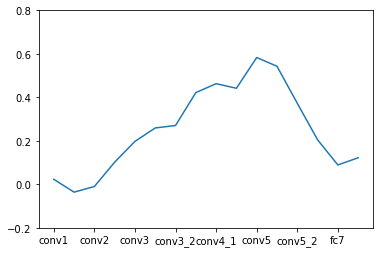

In [11]:
classes.correlate_integration_beauty(results_vgg16, places_images.beauty_ratings).plot(ylim=(-.2,.8))

In [10]:
classes.correlate_integration_beauty(results_autoencoding, places_images.beauty_ratings).plot(ylim=(-.2,.8))

NameError: name 'results_autoencoding' is not defined

In [8]:
results_vgg16

,conv1,conv1_1,conv2,conv2_1,conv3,conv3_1,conv3_2,conv4,conv4_1,conv4_2,conv5,conv5_1,conv5_2,fc6,fc7,fc8a
0,-0.983123,-0.972471,-0.969690,-0.932361,-0.870340,-0.867848,-0.861324,-0.792860,-0.836010,-0.784744,-0.770835,-0.837915,-0.801580,-0.912642,-0.904536,-0.849672
1,-0.988474,-0.970777,-0.970677,-0.946647,-0.920898,-0.911696,-0.896856,-0.846613,-0.840459,-0.799933,-0.826476,-0.891256,-0.900086,-0.964162,-0.961519,-0.962565
2,-0.989495,-0.973141,-0.974408,-0.953882,-0.930552,-0.923199,-0.912643,-0.869097,-0.878391,-0.830931,-0.818602,-0.889172,-0.871852,-0.951417,-0.935921,-0.919300
3,-0.989586,-0.980083,-0.977478,-0.946990,-0.907716,-0.904630,-0.890270,-0.855537,-0.864602,-0.815427,-0.821811,-0.884210,-0.901800,-0.961100,-0.958398,-0.965751
4,-0.991258,-0.981188,-0.978538,-0.949577,-0.909039,-0.907792,-0.890851,-0.865774,-0.892154,-0.851080,-0.847102,-0.883068,-0.875207,-0.959389,-0.953732,-0.941918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,-0.983311,-0.962983,-0.963242,-0.941431,-0.901636,-0.887660,-0.869910,-0.783837,-0.774626,-0.718336,-0.725431,-0.791481,-0.790926,-0.913020,-0.891236,-0.835036
246,-0.986610,-0.972127,-0.971881,-0.945548,-0.913277,-0.908537,-0.895740,-0.879633,-0.882571,-0.847796,-0.875402,-0.908133,-0.921162,-0.973889,-0.973316,-0.976925
247,-0.989653,-0.983949,-0.977510,-0.941544,-0.882314,-0.889077,-0.883545,-0.843965,-0.871419,-0.835822,-0.812478,-0.860232,-0.848119,-0.924650,-0.888101,-0.843361
248,-0.990375,-0.972764,-0.980901,-0.960154,-0.939933,-0.937857,-0.932748,-0.895055,-0.914636,-0.876649,-0.894824,-0.943529,-0.931882,-0.975520,-0.972920,-0.968108


In [12]:
places_images.beauty_ratings

0      86.00
1      70.76
2      33.68
3      35.84
4      40.72
       ...  
245    60.76
246    38.52
247    65.24
248    56.44
249    62.48
Length: 250, dtype: float64

# Inspect models (export data to matlab)

## Model parameters

In [18]:
state = dict(vgg16_places.state_dict())
savemat('../matlab analysis/PyVGG16_parameters.mat', {k.replace('.','_'):v.squeeze().detach().numpy() for k,v in state.items()}) # cant export variable names with . in them

## Activations to tensor of ones

In [36]:
one = torch.ones(1, 3, 224, 224).float()
one_response = vgg16_places_fe(one)
one_response = {key:value.squeeze().detach().numpy() for key,value in one_response.items()}
savemat('../matlab analysis/activations_onetensor.mat', one_response)

## Activations to tensor of hundrets

In [166]:
pass

## Activations to image 1153

In [ ]:
"""
Check if activation (matlab) and feature extraction (pytorch) return the same values
Can check also only correlations, which would include checking the image transformations. 

"""

In [165]:
# old code, maybe need this later for investigating why it produces such different activations 
#im = torchvision.io.read_image('./data/stimuli_places1/Places365_val_00001153.jpg')
#im = torchvision.transforms.Resize(size=(224,224))(im)
#im = im.unsqueeze(0)
#im.shape

torch.Size([1, 3, 224, 224])

In [212]:
# Import resized img1153 from matlab
img = torch.tensor(loadmat('./stimuli_places1_resized/Places365_val_00001153.mat')['im'])
img = img.permute((2, 0, 1))
img = img.unsqueeze(0)
img = img.float()
img = img.flip(1)
img.shape

torch.Size([1, 3, 224, 224])

In [213]:
img_act = vgg16_places_fe(img)

In [214]:
savemat('../matlab analysis/py_activations1153.mat', {key:value.squeeze().detach().numpy() for key,value in img_act.items()})

## Manually calculate activations

In [176]:
img.shape

torch.Size([1, 3, 224, 224])

In [181]:
X = img[:,:,1:3+1,1:3+1].squeeze().shape

In [187]:
W = vgg16_places_fe.state_dict()['conv1_1.weight'][0,:,:,:]

In [191]:
W.flip(0)

tensor([[[ 0.3468,  0.3786, -0.0225],
         [ 0.2262,  0.0798, -0.2800],
         [-0.1114, -0.2863, -0.3753]],

        [[ 0.3899,  0.4098, -0.0200],
         [ 0.2631,  0.1020, -0.2826],
         [-0.0947, -0.2817, -0.3859]],

        [[ 0.3372,  0.3692, -0.0315],
         [ 0.2289,  0.0854, -0.2699],
         [-0.1009, -0.2671, -0.3517]]])

## Predictions (without feature extractor)

### Predictions for img1153

In [210]:
output = vgg16_places(img.flip(0))
output.shape

torch.Size([1, 365])

In [211]:
sorted, indices = torch.sort(output, descending=True)
torch.round(sorted, decimals=5)

tensor([[7.8667e-01, 5.8050e-02, 5.1110e-02, 3.2630e-02, 1.1390e-02, 7.1900e-03,
         6.2200e-03, 5.8000e-03, 4.5800e-03, 4.2300e-03, 3.9500e-03, 3.6400e-03,
         3.5400e-03, 2.1400e-03, 1.8700e-03, 1.8600e-03, 1.3100e-03, 1.1500e-03,
         1.1000e-03, 8.3000e-04, 8.0000e-04, 6.7000e-04, 6.3000e-04, 6.1000e-04,
         5.0000e-04, 5.0000e-04, 4.1000e-04, 3.8000e-04, 3.8000e-04, 3.4000e-04,
         3.1000e-04, 3.1000e-04, 3.1000e-04, 3.0000e-04, 2.7000e-04, 2.2000e-04,
         2.2000e-04, 2.1000e-04, 1.8000e-04, 1.6000e-04, 1.5000e-04, 1.4000e-04,
         1.1000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04, 9.0000e-05,
         8.0000e-05, 8.0000e-05, 8.0000e-05, 7.0000e-05, 7.0000e-05, 6.0000e-05,
         6.0000e-05, 5.0000e-05, 5.0000e-05, 4.0000e-05, 4.0000e-05, 3.0000e-05,
         3.0000e-05, 3.0000e-05, 3.0000e-05, 3.0000e-05, 3.0000e-05, 3.0000e-05,
         3.0000e-05, 3.0000e-05, 3.0000e-05, 3.0000e-05, 3.0000e-05, 2.0000e-05,
         2.0000e-05, 2.0000e

In [164]:
indices

tensor([[355, 324, 110, 288, 154, 279, 167, 357, 180, 113, 205, 271, 356, 243,
          94,  97, 277, 150,  81,   9, 232,  62, 342, 145, 344,  78, 323, 204,
         224, 353, 197,  48, 151, 265, 187, 229,  36,   7,  79,  73, 111, 350,
         164, 266, 254, 186, 218, 325, 190, 141, 303, 214, 171, 137, 163,  10,
         326, 338, 152, 306, 194, 362, 307,  57, 249, 234, 153, 258, 233, 125,
         340, 122, 291,  30, 209,  85,  66, 195,  69, 354, 292,  96,  58,  50,
         247,  76, 334, 245, 117,  84, 347,  95, 116, 339,  59, 191, 251, 127,
         289, 270, 131, 294,  86, 330, 364, 220,   5,  21, 259,   8, 348, 309,
         310, 142,  53, 345, 358, 236, 360, 140, 193, 276, 305, 206,  68, 160,
         359, 308,  39, 268,  31,  56, 159,  83, 287,  43, 181, 252,  12, 278,
          45, 126, 261, 184,  13, 175,  88, 317, 215, 275, 297, 333,  63, 179,
          77, 104, 149, 349,  34,  16, 255,  35, 346,  49, 173,  23, 260, 106,
          52, 257,  19, 136, 295, 319, 273,   4, 322